In [168]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns

In [138]:
# Set random seed for reproducibility
RANDOM_STATE = 42

In [139]:
# 1. Loading the Dataset
print("Loading dataset...")
df = pd.read_csv("Duolingo_data_03_06_final_standardized.csv")
pd.set_option('display.max_columns', None)
df

Loading dataset...


,user_id,block_average_correctness,reverse_tap_average_correctness,reverse_translate_average_correctness,listen_average_correctness,block_average_response_time,reverse_tap_average_response_time,reverse_translate_average_response_time,listen_average_response_time,user_ability_score,average_blocks_per_session,average_blocks_per_day,average_sessions_per_day,session_length_variance,blocks_per_session_variance,blocks_per_day_variance,sessions_per_day_variance,session_count,block_count,listen,reverse_tap,reverse_translate,response_time_variance,churn_time,churn_time_category
0,+4kwmfjD,0.227673,0.133858,0.378947,0.375000,0.002246,0.031466,0.003641,0.008832,0.610942,0.508028,0.514156,0.444444,0.755147,0.789055,0.000000,0.000000,0.020408,0.067494,0.045997,0.0768,0.047328,0.163987,0.0,1
1,+IUzKF2l,0.332900,0.212815,0.500000,0.607595,0.002769,0.033279,0.003321,0.011009,0.646135,0.177752,0.045300,0.000000,0.329076,0.356443,0.441670,0.000000,0.183673,0.103226,0.063032,0.1304,0.039695,0.237942,22.0,4
2,+Xv/6Nop,0.229710,0.140162,0.375000,0.397849,0.005831,0.044804,0.004645,0.015200,0.606883,0.300131,0.130238,0.133333,0.539885,0.622328,0.744112,0.225838,0.102041,0.102730,0.068143,0.1208,0.051908,0.784566,5.0,1
3,+mMyHsNU,0.239135,0.000000,0.250307,0.225892,0.004481,0.000000,0.001964,0.008600,0.613978,0.322248,0.283126,0.355556,0.775884,0.715246,0.800309,0.458726,0.224490,0.214392,0.373083,0.0000,0.352672,0.536977,6.0,1
4,+ziSnwWC,0.169845,0.065789,0.266409,0.328947,0.005608,0.024309,0.006240,0.010858,0.590596,0.069626,0.036523,0.166667,0.320580,0.380484,0.539567,0.252993,0.387755,0.098263,0.061329,0.0856,0.111450,0.495177,13.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,y6797eWc,0.076945,0.015957,0.202454,0.090909,0.002950,0.014475,0.005458,0.009800,0.545205,0.123050,0.107305,0.333333,0.280746,0.191319,0.583260,0.376852,0.163265,0.066501,0.049404,0.0672,0.059542,0.700965,3.0,1
308,yka558y8,0.144504,0.103175,0.166065,0.175000,0.021478,0.014423,0.010699,0.063518,0.559939,0.176606,0.133635,0.277778,0.522893,0.604499,0.863963,0.584944,0.142857,0.081886,0.061329,0.0440,0.140458,0.897106,4.0,1
309,z/C43yrd,0.069785,0.044248,0.175258,0.088889,0.004046,0.030523,0.008156,0.009240,0.536617,0.075279,0.049183,0.222222,0.377410,0.472344,0.635845,0.376852,0.244898,0.065509,0.039182,0.0800,0.041221,0.434084,6.0,1
310,z9FlLLzt,0.122254,0.000000,0.104911,0.105263,0.006673,0.000000,0.003753,0.007835,0.545946,0.159404,0.120895,0.277778,0.410431,0.406270,0.520763,0.085736,0.142857,0.074442,0.045997,0.0000,0.215267,0.356913,3.0,1


In [140]:
# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nDataset info:")
print(df.info())

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nSummary statistics:")
print(df.describe())

Dataset shape: (312, 25)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   user_id                                  312 non-null    object 
 1   block_average_correctness                312 non-null    float64
 2   reverse_tap_average_correctness          312 non-null    float64
 3   reverse_translate_average_correctness    312 non-null    float64
 4   listen_average_correctness               312 non-null    float64
 5   block_average_response_time              312 non-null    float64
 6   reverse_tap_average_response_time        312 non-null    float64
 7   reverse_translate_average_response_time  312 non-null    float64
 8   listen_average_response_time             312 non-null    float64
 9   user_ability_score                       312 non-null    float64
 10  average_bl

In [141]:
# 2. Data Preprocessing
print("\nChecking for missing values:")
print(df.isnull().sum())

# Convert churn_time_category to categorical target (binary classification)
# Let's consider categories 3 and 4 as "will churn" (1) and categories 1 and 2 as "will not churn" (0)
# df['will_churn'] = df['churn_time_category'].apply(lambda x: 1 if x >= 3 else 0)

print("\nTarget distribution:")
print(df['churn_time_category'].value_counts())
# print(df['1'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))


Checking for missing values:
user_id                                    0
block_average_correctness                  0
reverse_tap_average_correctness            0
reverse_translate_average_correctness      0
listen_average_correctness                 0
block_average_response_time                0
reverse_tap_average_response_time          0
reverse_translate_average_response_time    0
listen_average_response_time               0
user_ability_score                         0
average_blocks_per_session                 0
average_blocks_per_day                     0
average_sessions_per_day                   0
session_length_variance                    0
blocks_per_session_variance                0
blocks_per_day_variance                    0
sessions_per_day_variance                  0
session_count                              0
block_count                                0
listen                                     0
reverse_tap                                0
reverse_translate        

In [142]:
# 3. Feature Selection
# Exclude the original target, churn_time (which would cause data leakage), and any other columns we don't want as features
features = [col for col in df.columns if col not in ['churn_time_category', 'user_id', 'churn_time']]
X = df[features]
y = df['churn_time_category']

print("\nSelected features:", features)


Selected features: ['block_average_correctness', 'reverse_tap_average_correctness', 'reverse_translate_average_correctness', 'listen_average_correctness', 'block_average_response_time', 'reverse_tap_average_response_time', 'reverse_translate_average_response_time', 'listen_average_response_time', 'user_ability_score', 'average_blocks_per_session', 'average_blocks_per_day', 'average_sessions_per_day', 'session_length_variance', 'blocks_per_session_variance', 'blocks_per_day_variance', 'sessions_per_day_variance', 'session_count', 'block_count', 'listen', 'reverse_tap', 'reverse_translate', 'response_time_variance']


In [143]:
# 4. Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 249
Testing samples: 63


In [144]:
# due to imbalanced dataset, use stratified train-test split
# X contains your features, y contains your target variable (churn_time_category)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,                 # 20% of data for testing
    random_state=RANDOM_STATE,     # For reproducibility
    stratify=y                     # This is the key parameter for stratified sampling
)

In [145]:
# Verify
# Before splitting
print("Original class distribution:")
print(y.value_counts(normalize=True))

# After splitting
print("\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTesting set class distribution:")
print(y_test.value_counts(normalize=True))

Original class distribution:
churn_time_category
1    0.394231
2    0.336538
3    0.230769
4    0.038462
Name: proportion, dtype: float64

Training set class distribution:
churn_time_category
1    0.393574
2    0.337349
3    0.228916
4    0.040161
Name: proportion, dtype: float64

Testing set class distribution:
churn_time_category
1    0.396825
2    0.333333
3    0.238095
4    0.031746
Name: proportion, dtype: float64


In [208]:
# 5. Train a basic Random Forest model
print("\nTraining a basic Random Forest model...")
rf_model = RandomForestClassifier(class_weight='balanced_subsample', # Automatically calculate weights inversely proportional to class frequencies in each bootstrap sample
                                  random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)


Training a basic Random Forest model...


RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

In [209]:
# Calculate training accuracy
y_train_pred = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy:.4f}")

Training accuracy: 1.0000



Basic model accuracy: 0.6667

Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.84      0.79        25
           2       0.59      0.62      0.60        21
           3       0.62      0.53      0.57        15
           4       0.00      0.00      0.00         2

    accuracy                           0.67        63
   macro avg       0.49      0.50      0.49        63
weighted avg       0.64      0.67      0.65        63


Confusion Matrix:
[[21  4  0  0]
 [ 5 13  3  0]
 [ 2  5  8  0]
 [ 0  0  2  0]]


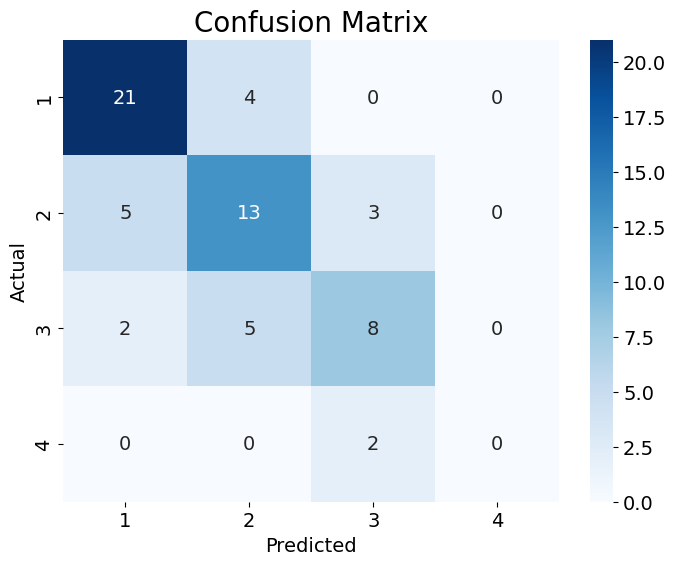

In [211]:
# 6. Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBasic model accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 7. Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['1', '2', '3', '4'],
            yticklabels=['1', '2', '3', '4'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Feature Importance:
                                    Feature  Importance
16                            session_count    0.107130
10                   average_blocks_per_day    0.085087
11                 average_sessions_per_day    0.084876
15                sessions_per_day_variance    0.054463
17                              block_count    0.052927
18                                   listen    0.051707
14                  blocks_per_day_variance    0.051230
13              blocks_per_session_variance    0.045842
8                        user_ability_score    0.044585
12                  session_length_variance    0.038602
0                 block_average_correctness    0.037998
9                average_blocks_per_session    0.036990
1           reverse_tap_average_correctness    0.035730
2     reverse_translate_average_correctness    0.033885
20                        reverse_translate    0.032527
21                   response_time_variance    0.031116
4               block_avera

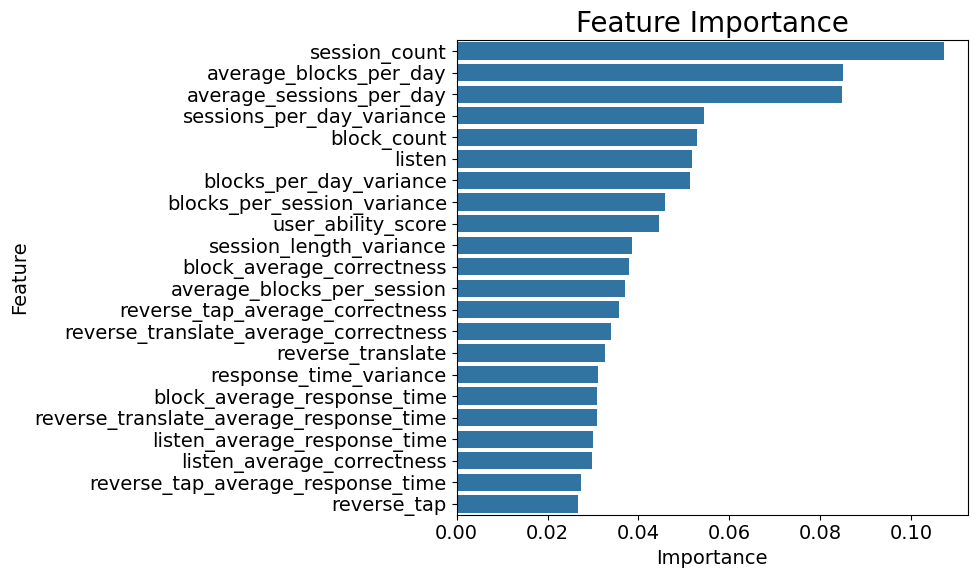

In [212]:
# 8. Feature Importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [198]:
# 9. Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

print("\nPerforming hyperparameter tuning...")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]  # Feature subsampling
}


grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))



Performing hyperparameter tuning...
Fitting 10 folds for each of 576 candidates, totalling 5760 fits


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.02s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0


Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.7307


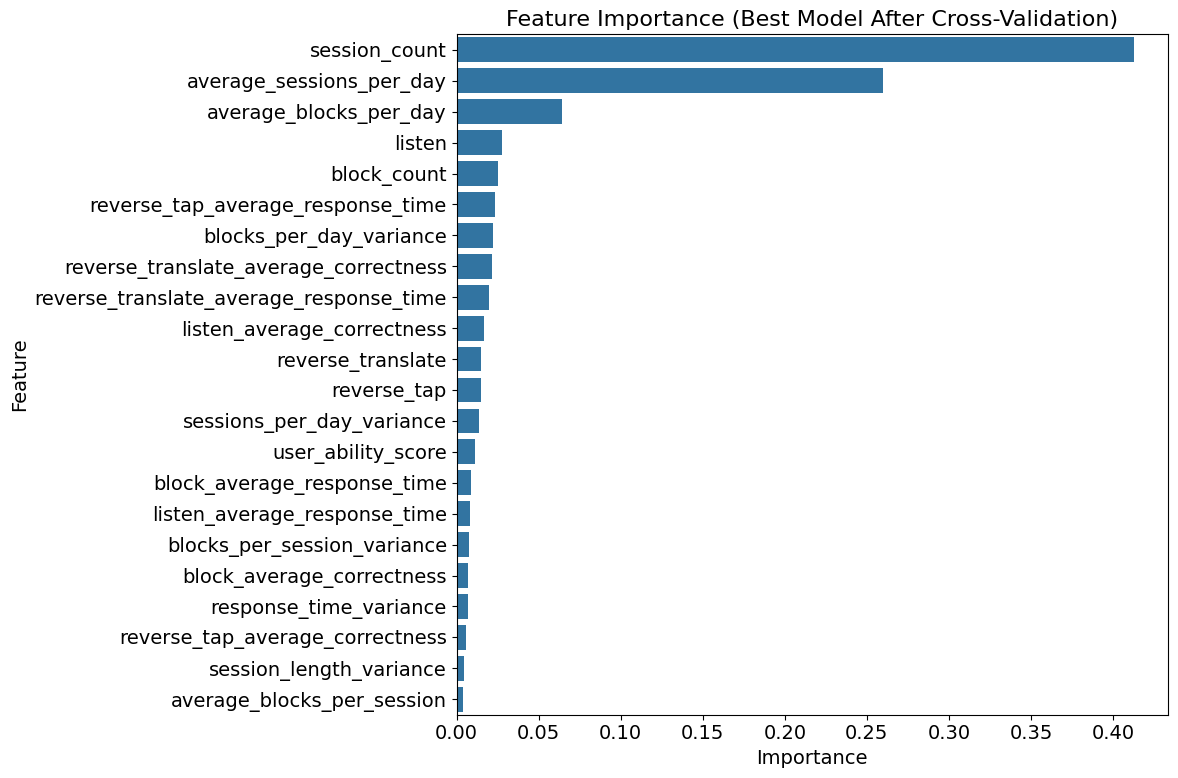

Top 15 most important features:
                                    Feature  Importance
16                            session_count    0.412840
11                 average_sessions_per_day    0.259876
10                   average_blocks_per_day    0.064026
18                                   listen    0.027498
17                              block_count    0.025169
5         reverse_tap_average_response_time    0.023215
14                  blocks_per_day_variance    0.022329
2     reverse_translate_average_correctness    0.021838
6   reverse_translate_average_response_time    0.019788
3                listen_average_correctness    0.016591
20                        reverse_translate    0.014821
19                              reverse_tap    0.014569
15                sessions_per_day_variance    0.013609
8                        user_ability_score    0.011147
4               block_average_response_time    0.008913


In [217]:
# Feature Importance visualization for your best model after CV
best_rf_model = grid_search.best_estimator_

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Create visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Best Model After Cross-Validation)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

# Print top 15 features
print("Top 15 most important features:")
print(feature_importance.head(15))

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0

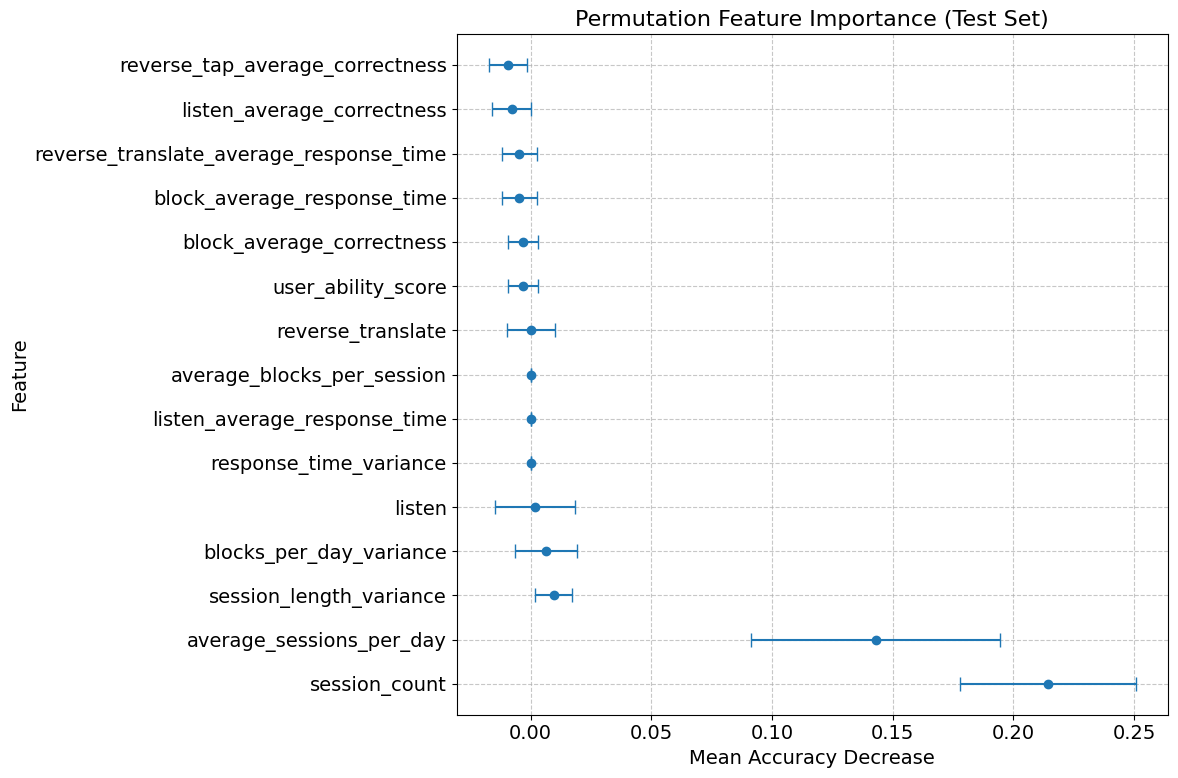

In [218]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance on test set
result = permutation_importance(
    best_rf_model, X_test, y_test, 
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Create DataFrame for visualization
perm_importance = pd.DataFrame({
    'Feature': features,
    'Importance': result.importances_mean,
    'Std': result.importances_std
})
perm_importance = perm_importance.sort_values('Importance', ascending=False)

# Create visualization with error bars
plt.figure(figsize=(12, 8))
plt.errorbar(
    x=perm_importance['Importance'][:15], 
    y=perm_importance['Feature'][:15],
    xerr=perm_importance['Std'][:15],
    fmt='o',
    capsize=5
)
plt.title('Permutation Feature Importance (Test Set)', fontsize=16)
plt.xlabel('Mean Accuracy Decrease', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [213]:
# 10. Evaluate the tuned model
best_rf_model = grid_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned model accuracy: {accuracy_tuned:.4f}")

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))



Tuned model accuracy: 0.6667

Classification Report (Tuned Model):
              precision    recall  f1-score   support

           1       0.77      0.80      0.78        25
           2       0.56      0.67      0.61        21
           3       0.67      0.53      0.59        15
           4       0.00      0.00      0.00         2

    accuracy                           0.67        63
   macro avg       0.50      0.50      0.50        63
weighted avg       0.65      0.67      0.66        63



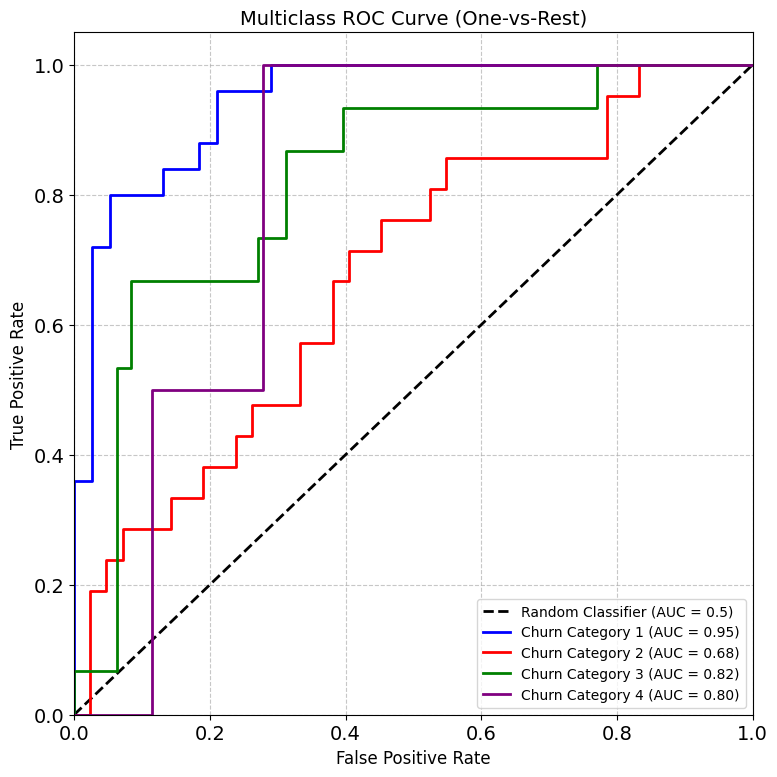

In [219]:
# 11. Multiclass ROC curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Train a multi-class classifier
clf = OneVsRestClassifier(RandomForestClassifier(**best_rf_model.get_params()))
clf.fit(X_train, label_binarize(y_train, classes=[1, 2, 3, 4]))

# Compute ROC curve and ROC area for each class
y_score = clf.predict_proba(X_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))

# Add diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')

# Plot ROC curve for each class with different colors
colors = ['blue', 'red', 'green', 'purple']
class_names = ['Churn Category 1', 'Churn Category 2', 'Churn Category 3', 'Churn Category 4']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Add labels, title and other visual elements
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multiclass ROC Curve (One-vs-Rest)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Set axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()


Generating learning curves...


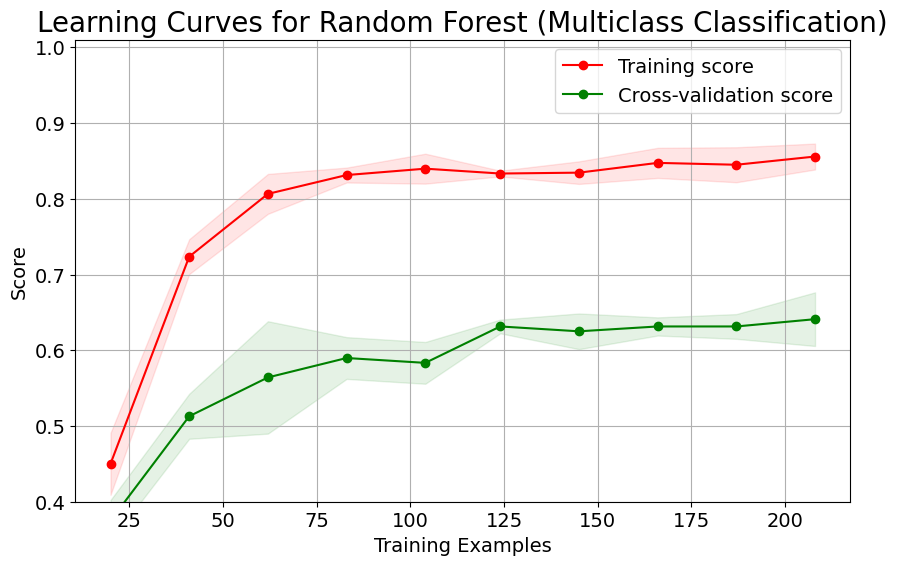

In [220]:
# 12. Learning Curves

print("\nGenerating learning curves...")
# Use StratifiedKFold instead of regular CV 
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

train_sizes, train_scores, test_scores = learning_curve(
    best_rf_model, X, y, 
    cv=cv,  # Use the stratified CV object
    n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
    # Note: random_state parameter is not used by learning_curve function directly
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curves for Random Forest (Multiclass Classification)')
plt.legend(loc='best')
plt.grid(True)
plt.ylim([0.4, 1.01])  # Set y-axis limits for better visualization
plt.show()

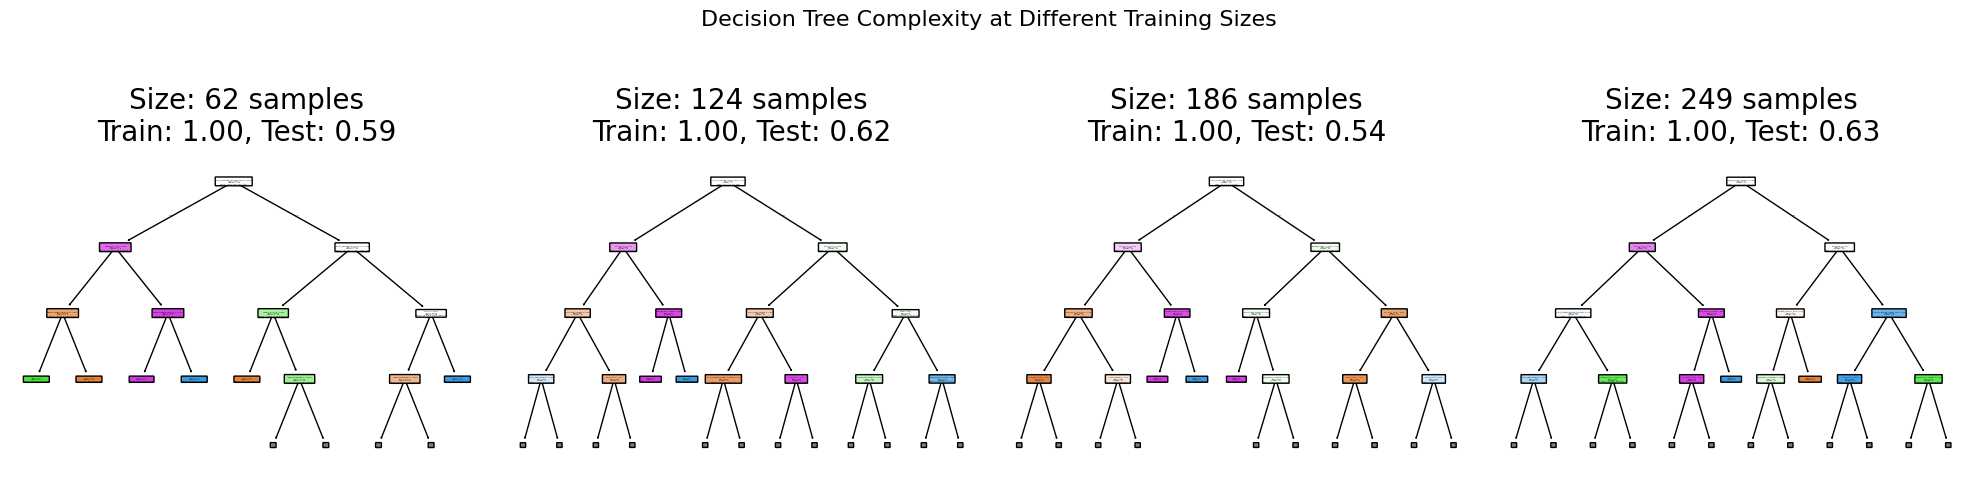

In [221]:
# Visualize trees at different training set sizes
from sklearn import tree

# Function to train models with different amounts of data and show trees
def visualize_trees_at_different_sizes(X_train, y_train, X_test, y_test, random_state=42, n_sizes=4):
    # Define training set sizes to evaluate
    train_sizes = np.linspace(0.25, 1.0, n_sizes)
    
    # Set up the plot grid
    fig, axes = plt.subplots(1, n_sizes, figsize=(20, 5))
    fig.suptitle('Decision Tree Complexity at Different Training Sizes', fontsize=16)
    
    # For each training size
    for i, train_size in enumerate(train_sizes):
        # Calculate number of samples for this size
        n_samples = int(len(X_train) * train_size)
        
        # Take a subset of training data
        indices = np.random.choice(len(X_train), n_samples, replace=False)
        X_subset = X_train.iloc[indices]
        y_subset = y_train.iloc[indices]
        
        # Train a Random Forest
        rf = RandomForestClassifier(class_weight='balanced_subsample', random_state=random_state)
        rf.fit(X_subset, y_subset)
        
        # Get scores
        train_score = rf.score(X_subset, y_subset)
        test_score = rf.score(X_test, y_test)
        
        # Plot one tree from the forest
        tree.plot_tree(
            rf.estimators_[0],  # Just visualize the first tree
            feature_names=X_train.columns,
            class_names=[str(c) for c in rf.classes_],
            filled=True,
            rounded=True,
            ax=axes[i],
            max_depth=3  # Limit depth for visualization
        )
        
        # Set title with size and scores
        axes[i].set_title(f'Size: {n_samples} samples\nTrain: {train_score:.2f}, Test: {test_score:.2f}')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call the function
visualize_trees_at_different_sizes(X_train, y_train, X_test, y_test)